In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

import shap
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

def plot_predictions(y_test, y_pred, y_pred_before, x_test, target, output_file='scatter_plot.png'):
    """
    Plots predicted vs actual values with different markers for "after TL" and "before TL"
    and color-coded by unique products.

    Parameters:
    - y_test: pd.Series or np.ndarray, actual target values
    - y_pred: pd.Series or np.ndarray, predicted values from the model after transfer learning
    - y_pred_before: pd.Series or np.ndarray, predicted values from the model before transfer learning
    - x_test: pd.DataFrame, feature set including the 'product_old' column
    - target: str, target variable name used in title and output
    - output_file: str, file name to save the plot (default: 'scatter_plot.png')
    """

    unique_products = x_test['product'].str.replace(' ', '').unique()
    colors = plt.cm.get_cmap('tab10', len(unique_products))
    color_dict = {product: colors(i) for i, product in enumerate(unique_products)}

    plt.figure(figsize=(8, 6))

    for product in unique_products:
        mask = x_test['product'] == product
        plt.scatter(y_test[mask], y_pred[mask], c=[color_dict[product]], label=f'{product}', alpha=0.5, marker='o')

    for product in unique_products:
        mask = x_test['product'] == product
        plt.scatter(y_test[mask], y_pred_before[mask], c=[color_dict[product]], alpha=0.5, marker='x')

    plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], 'k--')

    circle_patch = Line2D([], [], marker='o', color='w', markerfacecolor='gray', markersize=8, label='after TL')
    cross_patch = Line2D([], [], marker='x', color='w', markeredgecolor='gray', markersize=8, label='before TL')

    handles, labels = plt.gca().get_legend_handles_labels()

    #handles.extend([circle_patch, cross_patch])
    #labels.extend(['after TL', 'before TL'])

    plt.legend(handles, labels, loc='best', bbox_to_anchor=(1, 1))

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{target} predictions for all products')
    plt.tight_layout()
    plt.savefig(f'../figures/{output_file}', dpi=300)

def apply_imputation(df, rules):
    for _, row in rules.iterrows():
        feature = row.iloc[0]
        method = row.iloc[1]
        #print(f"Imputing {feature} with {method} method.")
        if feature in df.columns:
            if method == 'average':
                df[feature] = df[feature].astype('float64')
                mean_value = df[feature].mean()
                df.fillna({feature: mean_value}, inplace=True)
            elif method == 'mode':
                mode_value = df[feature].mode()[0]
                df.fillna({feature: mode_value}, inplace=True)
            elif method == 0:
                df.fillna({feature: 0}, inplace=True)
            elif method == 'na as a category':
                df[feature] = df[feature].astype('category')
                if 'missing' not in df[feature].cat.categories:
                    df[feature] = df[feature].cat.add_categories('missing')
                df.fillna({feature: 'missing'}, inplace=True)

def preprocess_data(df):
    encoder = OrdinalEncoder()
    cols = df.select_dtypes(include=['object', 'category']).columns
    df_enc = df.copy()
    df_enc[cols] = df_enc[cols].astype(str)
    df_enc[cols] = encoder.fit_transform(df_enc[cols])

    scaler = MinMaxScaler()
    df_scale = pd.DataFrame(scaler.fit_transform(df_enc), columns=df_enc.columns)

    return df_scale

def plot_top10_shap_values(model, model_before, features_to_include, x_test, target):
    """
    Plots the top 10 features with the highest SHAP values before and after transfer learning (TL).
    
    This function uses SHAP (SHapley Additive exPlanations) to interpret the contributions of features
    in two models. It highlights how the importance of the selected features changes between the models.
    
    Args:
        model: Trained model after transfer learning.
        model_before: Trained model before transfer learning.
        features_to_include: List of feature names to consider for SHAP value computation.
        x_test: DataFrame containing the test data used for SHAP value computation.
        target: Name of the target variable for the model (used in plot titles and file naming).
    
    Steps:
        1. Compute SHAP values for both models using the provided test data.
        2. Filter SHAP values and test data to include only the specified features.
        3. Calculate the mean absolute SHAP values for both models.
        4. Identify the top 10 features with the highest combined SHAP values.
        5. Create a scatter plot showing SHAP values for each model:
            - Use circles for the model after TL.
            - Use crosses for the model before TL.
        6. Use color mapping to represent the actual feature values.
        7. Save the plot as a PNG file in the `../figures/` directory.

    Output:
        - A scatter plot visualizing the top 10 feature contributions before and after transfer learning,
          with a color bar indicating the actual feature values.

    """

    explainer = shap.TreeExplainer(model)
    explainer2 = shap.TreeExplainer(model_before)
    shap_values = explainer.shap_values(x_test)
    shap_values2 = explainer2.shap_values(x_test)

    features_to_include_indices = [x_test.columns.get_loc(feature) for feature in features_to_include]

    filtered_shap_values = shap_values[:, features_to_include_indices]
    filtered_shap_values2 = shap_values2[:, features_to_include_indices]

    filtered_features = x_test[features_to_include]

    mean_abs_shap_values1 = np.mean(np.abs(filtered_shap_values), axis=0)
    mean_abs_shap_values2 = np.mean(np.abs(filtered_shap_values2), axis=0)

    # Get the top 10 features by average SHAP value for both before TL and after TL
    top_10_indices = np.argsort(mean_abs_shap_values1 + mean_abs_shap_values2)[-10:]
    top_10_features = np.array(features_to_include)[top_10_indices]

    # Filter SHAP values and feature data for top 10 features
    shap_values1_top10 = filtered_shap_values[:, top_10_indices]
    shap_values2_top10 = filtered_shap_values2[:, top_10_indices]
    X_test1_top10 = filtered_features.iloc[:, top_10_indices]
    X_test2_top10 = filtered_features.iloc[:, top_10_indices]

    fig, ax = plt.subplots()
    
    for i, feature in enumerate(top_10_features):
        # Normalize feature values for color mapping
        norm = plt.Normalize(vmin=X_test1_top10[feature].min(), vmax=X_test1_top10[feature].max())
        colors1 = plt.cm.coolwarm(norm(X_test1_top10[feature]))
        colors2 = plt.cm.coolwarm(norm(X_test2_top10[feature]))
        
        # Plot SHAP values for after TL with circles
        ax.scatter(shap_values1_top10[:, i], [i + 0.2] * len(shap_values1_top10), alpha=0.5, label='after TL' if i == 0 else "", marker='o', c=colors1)
        # Plot SHAP values for before TL with crosses
        ax.scatter(shap_values2_top10[:, i], [i - 0.2] * len(shap_values2_top10), alpha=0.5, label='before TL' if i == 0 else "", marker='x', c=colors2)

        ax.hlines(y=i, xmin=min(shap_values1_top10[:, i].min(), shap_values2_top10[:, i].min()), xmax=max(shap_values1_top10[:, i].max(), shap_values2_top10[:, i].max()), colors='grey', linestyles='dashed', alpha=0.3)
        
    ax.axvline(x=0, color='grey', linestyle='--')
    ax.set_yticks(np.arange(len(top_10_features)))
    ax.set_yticklabels(top_10_features)
    ax.set_xlabel("SHAP value (impact on model output)")
    ax.legend()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    legend_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=10, label='after TL'),
        Line2D([0], [0], marker='x', color='w', markeredgecolor='grey', markersize=10, label='before TL')
    ]
    ax.legend(handles=legend_handles, loc='best')
    
    color_bar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='coolwarm'), ax=ax, label='Actual feature value', aspect=30, pad=0.01, shrink=0.6)
    color_bar.outline.set_visible(False)  # Remove color bar frame
    plt.title(f'Feature importance for {target} prediction')
    plt.tight_layout()
    plt.savefig(f'../figures/{target}_shap.png', bbox_inches='tight', dpi=300)

target_feature:  OD
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test R² score before TL: 0.6691696010366878
Test R² score after TL with 20 worst trees: 0.7000294660549059


/var/folders/55/t_zqjgy51g3grkmnzctyfcxh0000gq/T/ipykernel_97855/3421498429.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_products))


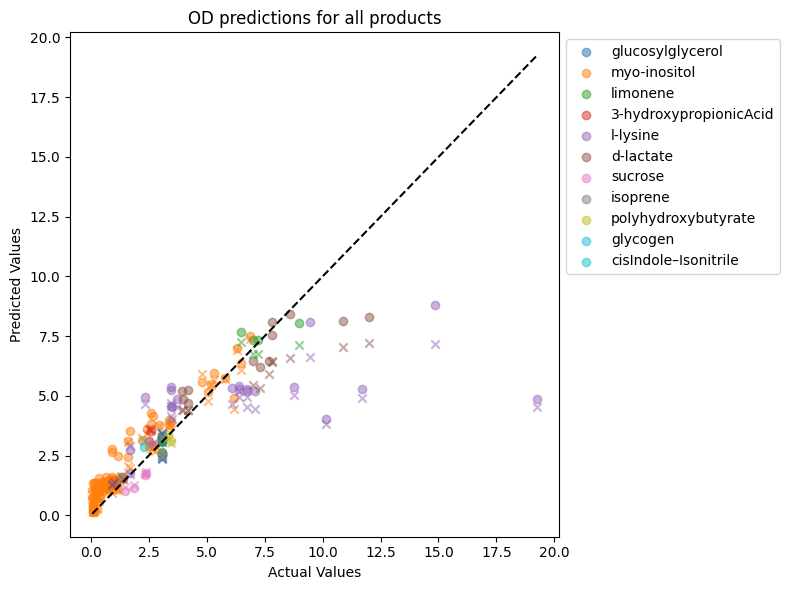

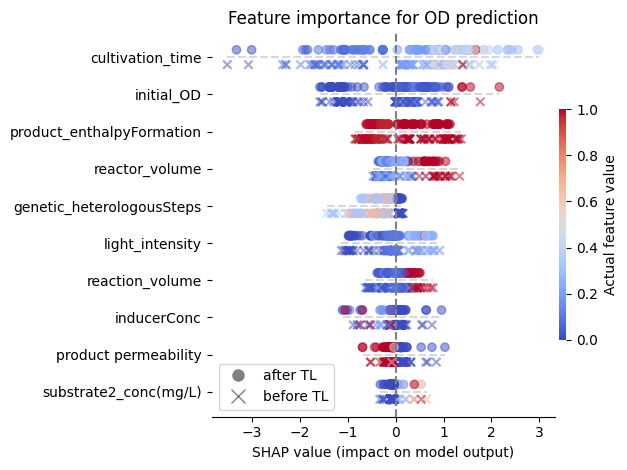

target_feature:  growth_rate
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test R² score before TL: 0.7220659477144563
Test R² score after TL with 20 worst trees: 0.7406819000264893


/var/folders/55/t_zqjgy51g3grkmnzctyfcxh0000gq/T/ipykernel_97855/3421498429.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_products))


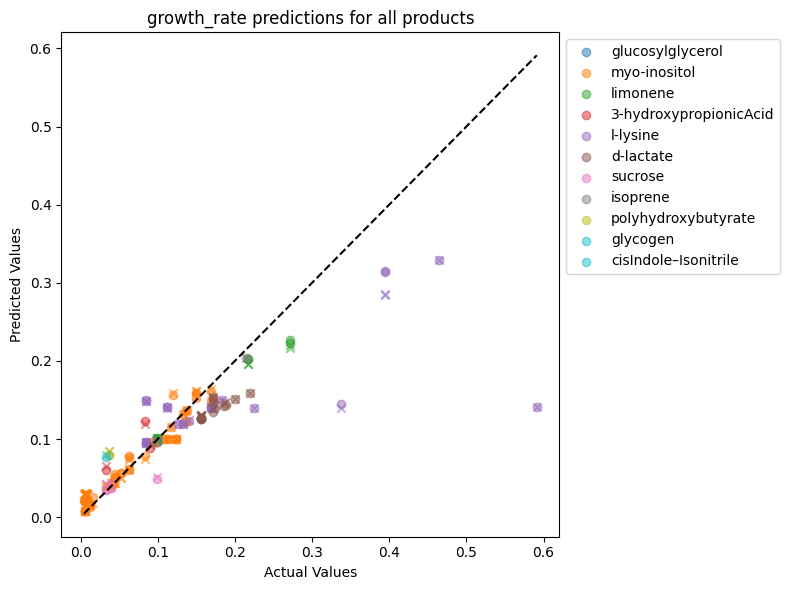

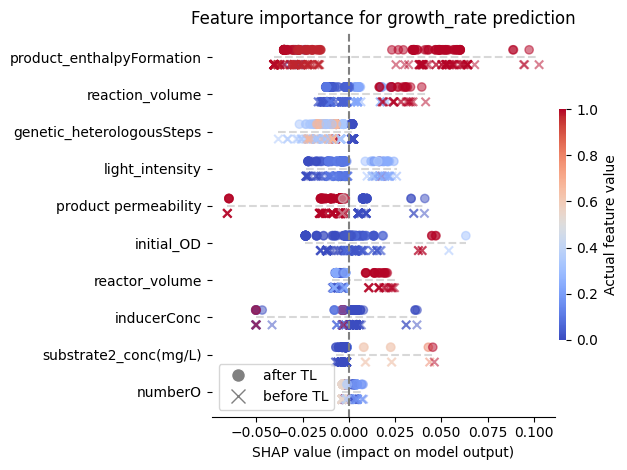

target_feature:  product_titer
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test R² score before TL: 0.6675464642639843
Test R² score after TL with 25 worst trees: 0.6790545832068966


/var/folders/55/t_zqjgy51g3grkmnzctyfcxh0000gq/T/ipykernel_97855/3421498429.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_products))


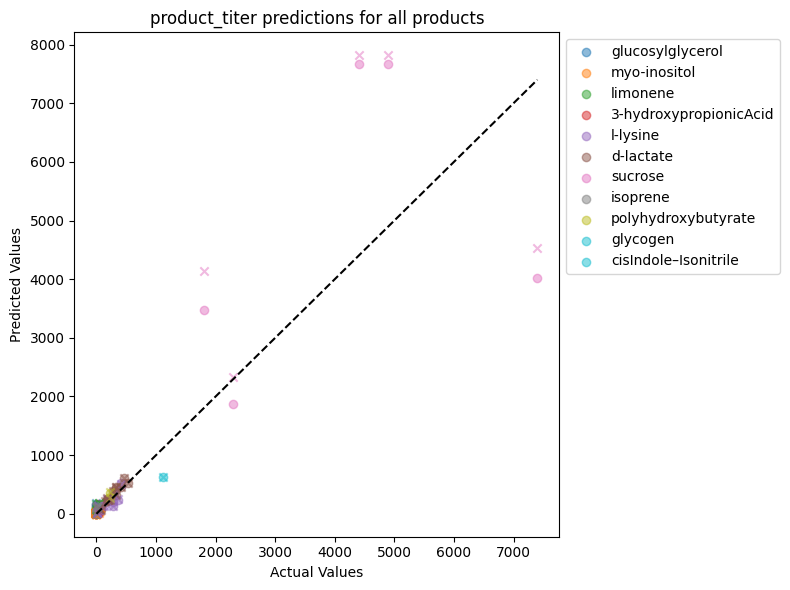

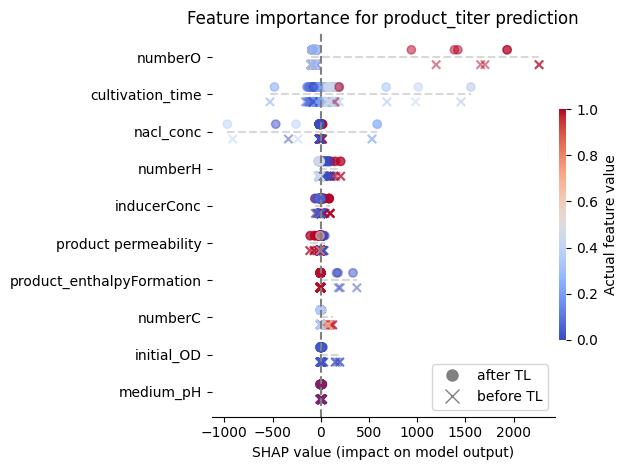

target_feature:  production_rate
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test R² score before TL: 0.6074172399595414
Test R² score after TL with 25 worst trees: 0.6106853607584382


/var/folders/55/t_zqjgy51g3grkmnzctyfcxh0000gq/T/ipykernel_97855/3421498429.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_products))


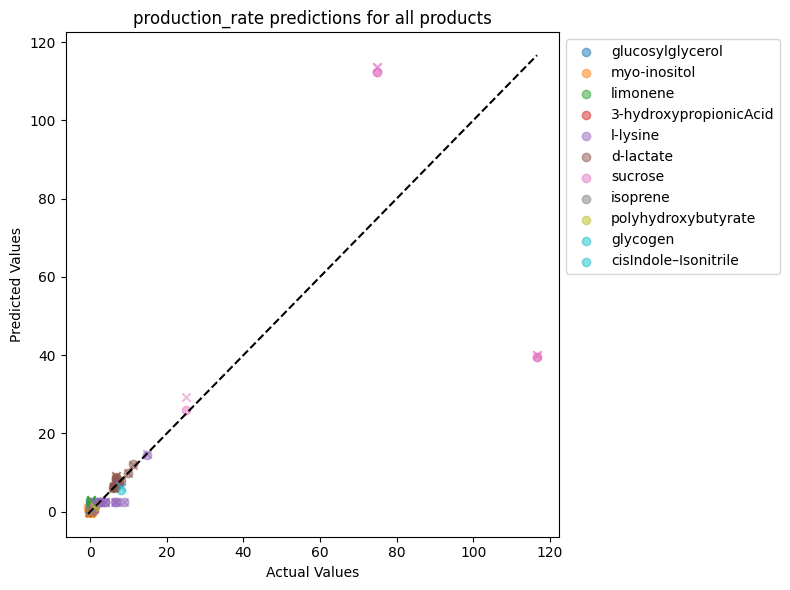

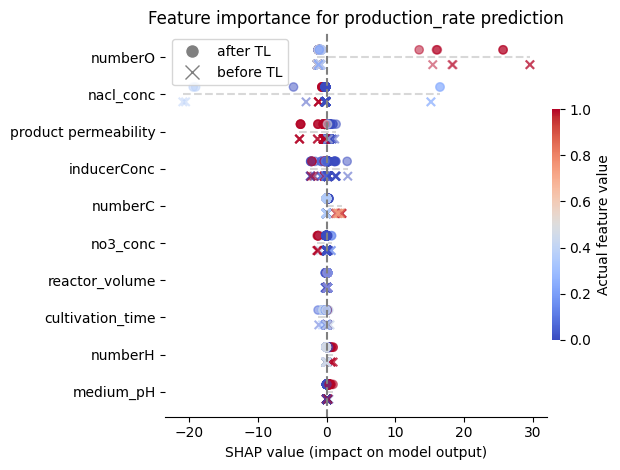

In [4]:
source_filename = "../data/6803_v2.xlsx"
source_filename2 = "../data/7942_v2.xlsx"
target_filename = "../data/2973_v2.xlsx"

df_source1 = pd.read_excel(source_filename, usecols=lambda x: x != 'Unnamed: 0', na_values=['na', ''])
df_source2 = pd.read_excel(source_filename2, usecols=lambda x: x != 'Unnamed: 0', na_values=['na', ''])
df_source = pd.concat([df_source1, df_source2], ignore_index=True)
df_target = pd.read_excel(target_filename, usecols=lambda x: x != 'Unnamed: 0', na_values=['na', ''])

imputation_rules = pd.read_excel('../data/impute.xlsx', header=None)

apply_imputation(df_source, imputation_rules)
apply_imputation(df_target, imputation_rules)

output_features = ['OD', 'growth_rate', 'product_titer', 'production_rate']
input_features = df_source.columns.difference(output_features + ['paper'])

df_source['paper'] = df_source['paper'].astype(int)
df_target['paper'] = df_target['paper'].astype(int)

for target in output_features:
    print("target_feature: ", target)
    X_train, X_test, y_train, y_test = train_test_split(df_target[input_features], df_target[target], test_size=0.2, random_state=42)
    X_train_processed = preprocess_data(X_train)
    X_test_processed = preprocess_data(X_test)
    X_source_processed = preprocess_data(df_source[input_features])

    rf_regressor = RandomForestRegressor(random_state=42)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True]
    }
    grid_search = GridSearchCV(
        estimator=rf_regressor,
        param_grid=param_grid,
        scoring='r2',
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_processed, y_train)
    best_rf = grid_search.best_estimator_
    best_rf_before = copy.deepcopy(best_rf)
    print("Best parameters:", grid_search.best_params_)

    y_pred_before = best_rf.predict(X_test_processed)
    r2 = r2_score(y_test, y_pred_before)
    print("Test R² score before TL:", r2)

    # Transfer
    tree_r2_scores = []
    for tree in best_rf.estimators_:
        y_pred_tree = tree.predict(X_test_processed.values)
        score = r2_score(y_test, y_pred_tree)
        tree_r2_scores.append(score)
    # Sort the trees ascending by r2
    sorted_tree_indices = np.argsort(tree_r2_scores)
    
    best_r2 = float('-inf')
    best_y_pred = None
    best_n = None
    n_worst_trees = [1,3,5,10,15,20,25]
    for n_tree in n_worst_trees:
        for idx, tree_idx in zip(range(n_tree), sorted_tree_indices[:n_tree]):
            tree = best_rf.estimators_[tree_idx]
            new_X_train = pd.concat([X_source_processed, X_train_processed], axis = 0)
            new_y_train = pd.concat([df_source[target], y_train], axis = 0)
            tree.fit(new_X_train, new_y_train)

        y_pred_after = best_rf.predict(X_test_processed)
        new_r2 = r2_score(y_test, y_pred_after)

        if new_r2 > best_r2:
            best_r2 = new_r2
            best_n = n_tree
            best_y_pred = y_pred_after
    
    print(f"Test R² score after TL with {best_n} worst trees:", best_r2)
    plot_predictions(y_test, best_y_pred, y_pred_before, X_test, target, output_file=f'{target}_scatter_plot.png')

    features_to_include = ['temperature', 'light_intensity', 'light_dark_ratio', 'reactor_volume',
        'reaction_volume', 'initial_OD', 'cultivation_time', 'no3_conc',
        'phosphate_conc', 'co2_perc', 'air_bubbling', 'bubbling_speed (ml/min)',
        'hco3_conc', 'nacl_conc', 'medium_pH', 'substrate2_conc(mg/L)',
        'substrate2_enthalpyFormation', 'genetic_wt', 'inducerConc',
        'genetic_mutation', 'genetic_knockoutSteps', 'genetic_enzymaticSteps',
        'genetic_heterologousSteps', 'pathwayOptimized', 'numberC', 'numberH',
        'numberN', 'numberO', 'product_enthalpyFormation', 'product permeability']
    plot_top10_shap_values(best_rf, best_rf_before, features_to_include, X_test_processed, target)
